In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load and Preprocess CIFAR-10 Dataset

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
# subsample for efficiency
train_sample, test_sample = 10000, 2000
train_idx = np.random.choice(len(x_train), train_sample, replace=False)
test_idx = np.random.choice(len(x_test), test_sample, replace=False)

x_train, y_train_cat = x_train[train_idx], y_train_cat[train_idx]
x_test, y_test_cat = x_test[test_idx], y_test_cat[test_idx]
y_test_raw = y_test[test_idx]

In [5]:
def preprocess_dataset(x, y, target_size=224):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(lambda img, label: (tf.image.resize(img, [target_size, target_size]), label),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_dataset(x_train, y_train_cat)
test_ds = preprocess_dataset(x_test, y_test_cat)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# EfficientNetB0 Transfer Learning

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet(input_shape=(224, 224, 3), num_classes=10):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
efficientnet_model = build_efficientnet()
efficientnet_model.fit(train_ds, validation_data=test_ds, epochs=3)
efficientnet_results = efficientnet_model.evaluate(test_ds)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 110ms/step - accuracy: 0.0910 - loss: 2.3359 - val_accuracy: 0.1075 - val_loss: 2.3025
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.0946 - loss: 2.3026 - val_accuracy: 0.1015 - val_loss: 2.3026
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1013 - loss: 2.3027 - val_accuracy: 0.1015 - val_loss: 2.3027
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1079 - loss: 2.3022


# BiT via ResNet50V2

In [8]:
from tensorflow.keras.applications import ResNet50V2

def build_bit(input_shape=(224, 224, 3), num_classes=10):
    base = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [9]:
bit_model = build_bit()
bit_model.fit(train_ds, validation_data=test_ds, epochs=3)
bit_results = bit_model.evaluate(test_ds)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 124ms/step - accuracy: 0.6651 - loss: 0.9890 - val_accuracy: 0.8105 - val_loss: 0.5468
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.8303 - loss: 0.4777 - val_accuracy: 0.8300 - val_loss: 0.5059
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8632 - loss: 0.3714 - val_accuracy: 0.8350 - val_loss: 0.5079
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8442 - loss: 0.4738


# ConvNeXt-Inspired CNN

In [10]:
def build_convnext(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(96, 4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    for filters in [192, 384, 768]:
        shortcut = layers.Conv2D(filters, 2, strides=2, padding="same")(x)
        shortcut = layers.LayerNormalization(epsilon=1e-6)(shortcut)
        x = layers.DepthwiseConv2D(7, padding="same")(shortcut)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters * 4, 1, activation="gelu")(x)
        x = layers.Conv2D(filters, 1)(x)
        x = layers.Add()([x, shortcut])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [11]:
convnext_model = build_convnext()
convnext_model.fit(train_ds, validation_data=test_ds, epochs=2)
convnext_results = convnext_model.evaluate(test_ds)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - accuracy: 0.1009 - loss: 4.9342 - val_accuracy: 0.0995 - val_loss: 2.3925
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.1043 - loss: 2.4781 - val_accuracy: 0.0980 - val_loss: 2.3395
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1028 - loss: 2.3407


# Compare Model

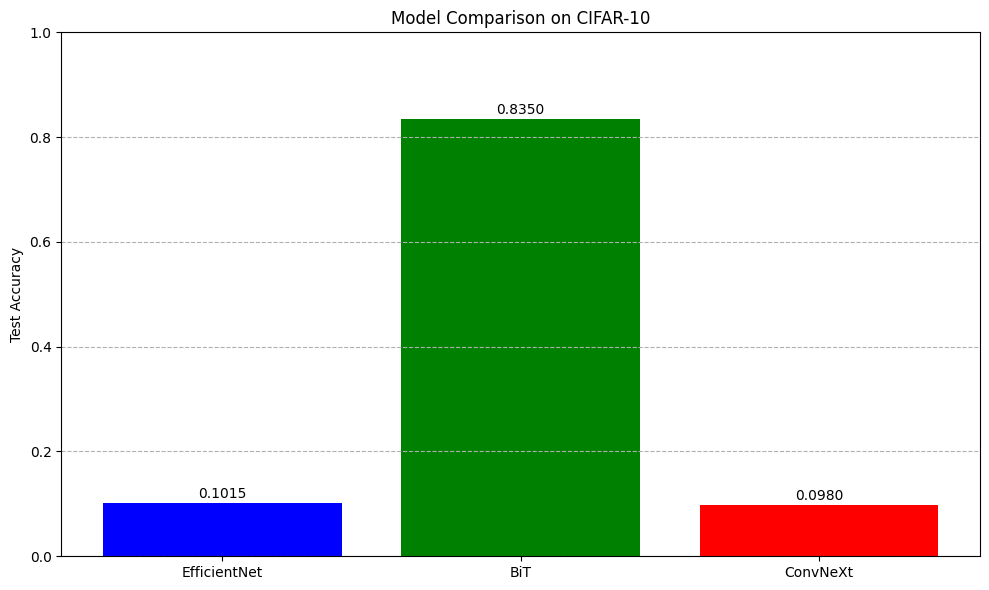

In [12]:
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on CIFAR-10')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Best Model Predictions

Best model: BiT with accuracy: 0.8350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


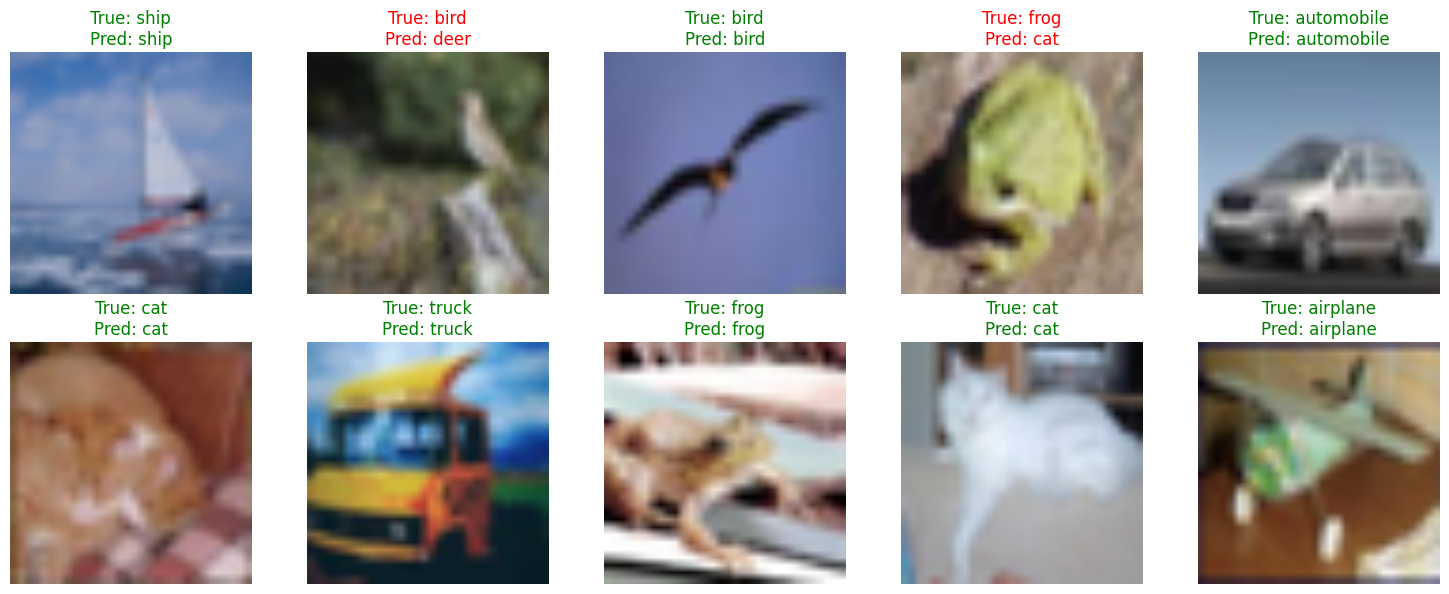

In [14]:
def plot_sample_predictions(model, dataset, class_names, num_samples=10):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow((images[i].numpy() * 255).astype("uint8"))
            color = 'green' if pred_classes[i] == true_classes[i] else 'red'
            plt.title(f'True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}', color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        break

# visualize best model
best_idx = np.argmax(accuracies)
best_model = [efficientnet_model, bit_model, convnext_model][best_idx]
print(f"Best model: {model_names[best_idx]} with accuracy: {accuracies[best_idx]:.4f}")
plot_sample_predictions(best_model, test_ds, class_names)